# Race prediction using demographic data

## Introduction

#### This notebook creates a model to predict whether an individual is of hispanic origin based on a number of factors available in US Census. It then builds another model to predict "high income" individuals, and measures the model bias using direct & proxy methods.

User will have to request a data download (free) from IPUMS USA themselves - https://usa.ipums.org/usa/about.shtml

Data description details can be found at the link below: <br>
https://docs.google.com/document/d/1RVYKlNVE5pepIYnt645VSrWf_cPOJNBVhoWNKXRbKdk/edit?usp=sharing

Analysis sections of this notebook: <br>
0. Import packages
1. Read data and apply filters / clean-ups
2. Build MSA-level historical features
3. Build hispanic proxy model
4. Interpret model drivers and evaluate performance
5. Build high income model, exclude PG variables from inputs
6. Run fairness scenarioes to measure bias / performance tradeoff
7. Interpret model drivers, performance and bias

### 1. Imports

In [1]:
# Import analysis libraries
import time
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import log_loss
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn import datasets, metrics, model_selection, svm


# from notebooks/ directory
import sys, os

# ADDITIONS:
from src.RAI import DataBiasChecker, ModelBiasRanker, ModelBiasHandler

# Python settings
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)


### 2. Read data

In [4]:
## Download input file from BCG Egnyte - RAI folder
## https://bcg01.egnyte.com/navigate/folder/881ba5c2-8f6e-4eb6-b940-848faa78dee9
model_input_path = './data/raw/usa_IPUMS_2022.csv.gz'
ipums_select = pd.read_csv(model_input_path, compression='gzip', header=0, sep=',', quotechar='"', error_bad_lines=False,
                       usecols = ['INCTOT','AGE','YEAR','MET2013','RACE','HISPAN', 'RENT','MORTGAGE',
                     'SERIAL', 'CBSERIAL', 'NUMPREC', 'SUBSAMP', 'HHWT','HHTYPE', 'EDUC', 'MARST'])


In [ ]:
ipums_select

### Filter down to working age (18-80) records for which we have income

In [5]:
def clean_age_income(model_input):
    
    # Remove Missing values
    # model_input.INCTOT.max()
    # 9999999
    print("Starting individual/year records: ", model_input.shape)
    model_input = model_input[model_input['INCTOT'] != 9999999]
    model_input = model_input[model_input['INCTOT'] > 0]
    print("Removing null income - remaining records: ", model_input.shape)
    # model_input.INCTOT.hist(bins = 50)
    model_input = model_input[model_input['AGE'] > 18]
#     model_input = model_input[model_input['AGE'] < 80]
    print("Removing ages <18 & >80 - remaining records: ", model_input.shape)
    # model_input.AGE.hist(bins = 61)
    
    return(model_input)

In [6]:
def create_race_groupings(model_input):
    #### Group based on US Census race definitions

    # Group 1: Asian
    # Group 2: White, not Hispanic
    # Group 3: Hispanic (any race)
    # Group 4: Black

    # by group
    conditions = [
        (model_input.HISPAN == 1),
        (model_input.RACE == 4) | (model_input.RACE == 5) | (model_input.RACE == 6),
        (model_input.RACE == 1) & (model_input.HISPAN == 0),
        (model_input.RACE == 2)
    ]

    choices = ['Hispanic any race', 'Asian', 'White not Hispanic', 'Black']
    model_input['race_group'] = np.select(conditions, choices, default='Other race')
    model_input['non_white'] = 1 - np.where(model_input['race_group'] == 'White not Hispanic', 1, 0)
    model_input['hispanic'] = np.where(model_input['race_group'] == 'Hispanic any race', 1, 0)
    model_input['black'] = np.where(model_input['race_group'] == 'black', 1, 0)
    model_input['asian'] = 1 - np.where(model_input['race_group'] == 'Asian', 1, 0)
    model_input['other_race'] = np.where(model_input['race_group'] == 'Other race', 1, 0)


    ### Not super representative of the US - skews more white
    # print(model_input['RACE_Grp'].value_counts(normalize=True))

    return model_input

In [7]:
model_input = clean_age_income(ipums_select)

Starting individual/year records:  (15947624, 16)
Removing null income - remaining records:  (11607441, 16)
Removing ages <18 & >80 - remaining records:  (11281261, 16)


In [8]:
model_input = create_race_groupings(model_input)

In [ ]:
missing.RACE.value_counts()

### Create a binary target variables

In [9]:
model_input['hispanic'] = np.where(model_input.HISPAN == 1,1,0)
model_input['hispanic'].value_counts(normalize=True)

0   0.929
1   0.071
Name: hispanic, dtype: float64

In [10]:
np.where(model_input.HISPAN == 1,1,0)

array([0, 0, 0, ..., 0, 0, 0])

In [11]:
model_input['hispanic'].to_numpy()

array([0, 0, 0, ..., 0, 0, 0])

In [12]:
(model_input['hispanic'].to_numpy() == np.where(model_input.HISPAN == 1,1,0)).sum()

11281261

### 3. Create MSA Historical features

In [13]:
# select only historical data for training
model_input_historical = model_input[model_input['YEAR'] < 2020]
targets = ['hispanic', 'INCTOT', 'AGE']

In [15]:
def msa_extractor(model_input, model_input_historical, targets):
    summary_df_yr_msa = pd.DataFrame(model_input_historical.groupby('MET2013')[targets].mean())
    summary_df_yr_msa = summary_df_yr_msa.reset_index()
    summary_df_yr_msa.columns = ['MET2013', 'msa_hispanic_density','msa_median_INCTOT','msa_AGE']
    
    model_input = model_input.merge(summary_df_yr_msa, on = 'MET2013')

    print(summary_df_yr_msa.head(2))
    
    return(model_input)

In [16]:
model_input = msa_extractor(model_input, model_input_historical, targets)

   MET2013  msa_hispanic_density  msa_median_INCTOT  msa_AGE
0        0                 0.033          38255.515   53.050
1    10420                 0.005          45092.570   51.564


### Input parameters <- re-run start here

In [17]:
# set parameters for bias check
dependent = 'hispanic'  # dependent variable we measure
dependent_bin = 'hispanic_origin'

### Take sample and build model input dataframe

In [18]:
model_sample = model_input.sample(n=200000, random_state = 42)

In [19]:
# Encode chose parameter for disadvantaged class as binary variable
model_sample[dependent_bin] = model_sample[dependent]

##### Run functions to create dummies for categorical variables and normalize numeric
num_vars = ['RENT','MORTGAGE', 'AGE', 'INCTOT', 'msa_hispanic_density','msa_median_INCTOT','msa_AGE']

cat_vars = ['EDUC','MARST', 'HHTYPE']

In [20]:
def normalize_num(df, num_cols):
    """
    This function normalizes numeric variables

    Args:
        df: pandas df with numeric columns to normalize
        num_cols: list of numeric column names

    Result:
        Returns same dataframe with normalized data
    """

    x = df[num_cols].values  # returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    df_num = pd.DataFrame(x_scaled)
    df_num.columns = num_cols
    df_num = df_num.reset_index(drop=True)

    df_drop = df.drop(num_cols, axis=1)
    df_drop = df_drop.reset_index(drop=True)
    df_final = pd.concat([df_drop, df_num], axis=1)

    return df_final

In [21]:
def model_input_build(model_sample,num_vars,cat_vars):

    # This is an internal function which one-hot encodes all categorical and normalizes all numeric variables
    model_data_norm = normalize_num(model_sample, num_vars)
    model_data_cat = pd.get_dummies(model_sample[cat_vars], columns=cat_vars)
    model_data_num = model_data_norm[num_vars]

    # temp fix issue with multiple indices, creating more rows
    model_data_num.index = model_sample.index
    model_data_norm.index = model_sample.index
    model_data_cat.index = model_sample.index

    # Join
    model_data_norm['ID'] = model_data_norm.index
    model_data = pd.concat([model_data_norm[[dependent_bin, "ID"]], model_data_cat, model_data_num], axis=1)

    # Print shape of final machine-learning ready data frame
    print("Model data shape: ", model_data.shape)
    
    return(model_data)

In [22]:
model_data = model_input_build(model_sample,num_vars,cat_vars)

Model data shape:  (200000, 35)


In [23]:
model_data.shape

(200000, 35)

### Build toy model - measure AUC and Accuracy

In [24]:
from seaborn import load_dataset
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
import shap


X = model_data.drop(labels=[dependent_bin], axis=1)
X = X.drop(labels=['ID'], axis=1)
# Run once without INCTOT - see if proxy bias lower
X = X.drop(labels=['INCTOT'], axis=1)

y = model_data[dependent_bin]

features = X.columns
cat_features = []
for cat in X.select_dtypes(exclude="number"):
    cat_features.append(cat)
    X[cat] = X[cat].astype("category").cat.codes.astype("category")

X_train, X_val, y_train, y_val = train_test_split(X,y,train_size=.8, random_state=42)

clf = LGBMClassifier(max_depth=3, n_estimators=1000, objective="binary")
clf.fit(X_train,y_train, eval_set=(X_val,y_val), early_stopping_rounds=100, verbose=100) 

[100]	valid_0's binary_logloss: 0.168239
[200]	valid_0's binary_logloss: 0.167087
[300]	valid_0's binary_logloss: 0.166911
[400]	valid_0's binary_logloss: 0.166841


LGBMClassifier(max_depth=3, n_estimators=1000, objective='binary')

### AUC

[2022-07-20 19:01:27,775 | DEBUG]	Loaded backend module://matplotlib_inline.backend_inline version unknown.
[2022-07-20 19:01:27,777 | DEBUG]	Loaded backend module://matplotlib_inline.backend_inline version unknown.
[2022-07-20 19:01:27,780 | DEBUG]	findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
[2022-07-20 19:01:27,781 | DEBUG]	findfont: score(FontEntry(fname='/Users/weulassagoujacques/opt/anaconda3/envs/facet-develop/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif-BoldItalic.ttf', name='DejaVu Serif', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
[2022-07-20 19:01:27,781 | DEBUG]	findfont: score(FontEntry(fname='/Users/weulassagoujacques/opt/anaconda3/envs/facet-develop/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizThreeSymReg.ttf', name='STIXSizeThreeSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[2

[2022-07-20 19:01:27,798 | DEBUG]	findfont: score(FontEntry(fname='/Users/weulassagoujacques/opt/anaconda3/envs/facet-develop/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizThreeSymBol.ttf', name='STIXSizeThreeSym', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
[2022-07-20 19:01:27,799 | DEBUG]	findfont: score(FontEntry(fname='/Users/weulassagoujacques/opt/anaconda3/envs/facet-develop/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/cmb10.ttf', name='cmb10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[2022-07-20 19:01:27,799 | DEBUG]	findfont: score(FontEntry(fname='/Users/weulassagoujacques/opt/anaconda3/envs/facet-develop/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneralBolIta.ttf', name='STIXGeneral', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
[2022-07-20 19:01:27,800 | DEBUG]	findfont: score(FontEn

[2022-07-20 19:01:27,819 | DEBUG]	findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/STIXNonUniBolIta.otf', name='STIXNonUnicode', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
[2022-07-20 19:01:27,819 | DEBUG]	findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/DIN Condensed Bold.ttf', name='DIN Condensed', style='normal', variant='normal', weight=700, stretch='condensed', size='scalable')) = 10.535
[2022-07-20 19:01:27,820 | DEBUG]	findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Devanagari Sangam MN.ttc', name='Devanagari Sangam MN', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[2022-07-20 19:01:27,821 | DEBUG]	findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Times New Roman.ttf', name='Times New Roman', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[2022-07-20 19:01:27,821 | DEBUG

[2022-07-20 19:01:27,842 | DEBUG]	findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Academy Engraved LET Fonts.ttf', name='Academy Engraved LET', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[2022-07-20 19:01:27,843 | DEBUG]	findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/STIXIntSmBol.otf', name='STIXIntegralsSm', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
[2022-07-20 19:01:27,843 | DEBUG]	findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansSharada-Regular.ttf', name='Noto Sans Sharada', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[2022-07-20 19:01:27,844 | DEBUG]	findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansHanunoo-Regular.ttf', name='Noto Sans Hanunoo', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[2022-07-20 19

[2022-07-20 19:01:27,866 | DEBUG]	findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Sinhala Sangam MN.ttc', name='Sinhala Sangam MN', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[2022-07-20 19:01:27,867 | DEBUG]	findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansShavian-Regular.ttf', name='Noto Sans Shavian', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[2022-07-20 19:01:27,867 | DEBUG]	findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSerifAhom-Regular.ttf', name='Noto Serif Ahom', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[2022-07-20 19:01:27,868 | DEBUG]	findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/STIXSizOneSymBol.otf', name='STIXSizeOneSym', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
[2022-07-20 19:01:27,869 | 

[2022-07-20 19:01:27,891 | DEBUG]	findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Gurmukhi Sangam MN.ttc', name='Gurmukhi Sangam MN', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[2022-07-20 19:01:27,891 | DEBUG]	findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSerifBalinese-Regular.ttf', name='Noto Serif Balinese', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[2022-07-20 19:01:27,892 | DEBUG]	findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansWancho-Regular.ttf', name='Noto Sans Wancho', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[2022-07-20 19:01:27,893 | DEBUG]	findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansLydian-Regular.ttf', name='Noto Sans Lydian', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[2022-07-20 

[2022-07-20 19:01:27,913 | DEBUG]	findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Verdana Bold.ttf', name='Verdana', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 3.9713636363636367
[2022-07-20 19:01:27,913 | DEBUG]	findfont: score(FontEntry(fname='/System/Library/Fonts/ヒラギノ角ゴシック W1.ttc', name='Hiragino Sans', style='normal', variant='normal', weight=200, stretch='normal', size='scalable')) = 10.24
[2022-07-20 19:01:27,914 | DEBUG]	findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansWarangCiti-Regular.ttf', name='Noto Sans Warang Citi', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[2022-07-20 19:01:27,914 | DEBUG]	findfont: score(FontEntry(fname='/System/Library/Fonts/STHeiti Medium.ttc', name='Heiti TC', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[2022-07-20 19:01:27,915 | DEBUG]	findfont: score(FontEntry(fname=

[2022-07-20 19:01:27,932 | DEBUG]	findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/PTMono.ttc', name='PT Mono', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
[2022-07-20 19:01:27,933 | DEBUG]	findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Bodoni 72.ttc', name='Bodoni 72', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[2022-07-20 19:01:27,934 | DEBUG]	findfont: score(FontEntry(fname='/System/Library/Fonts/Optima.ttc', name='Optima', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[2022-07-20 19:01:27,934 | DEBUG]	findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Arial Bold.ttf', name='Arial', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 6.698636363636363
[2022-07-20 19:01:27,934 | DEBUG]	findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSans

[2022-07-20 19:01:27,950 | DEBUG]	findfont: score(FontEntry(fname='/System/Library/Fonts/ヒラギノ角ゴシック W4.ttc', name='Hiragino Sans', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[2022-07-20 19:01:27,950 | DEBUG]	findfont: score(FontEntry(fname='/System/Library/Fonts/SFCompactRounded.ttf', name='.SF Compact Rounded', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[2022-07-20 19:01:27,951 | DEBUG]	findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansOsmanya-Regular.ttf', name='Noto Sans Osmanya', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[2022-07-20 19:01:27,951 | DEBUG]	findfont: score(FontEntry(fname='/System/Library/Fonts/Avenir Next Condensed.ttc', name='Avenir Next Condensed', style='normal', variant='normal', weight=700, stretch='condensed', size='scalable')) = 10.535
[2022-07-20 19:01:27,952 | DEBUG]	findfont: score(FontEntry

[2022-07-20 19:01:27,969 | DEBUG]	findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansOsage-Regular.ttf', name='Noto Sans Osage', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[2022-07-20 19:01:27,969 | DEBUG]	findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Raanana.ttc', name='Raanana', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[2022-07-20 19:01:27,970 | DEBUG]	findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Trebuchet MS Bold.ttf', name='Trebuchet MS', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
[2022-07-20 19:01:27,970 | DEBUG]	findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/GillSans.ttc', name='Gill Sans', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[2022-07-20 19:01:27,971 | DEBUG]	findfont: score(FontEntry(fname='/Sys

[2022-07-20 19:01:27,990 | DEBUG]	findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Courier New Bold.ttf', name='Courier New', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
[2022-07-20 19:01:27,991 | DEBUG]	findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansOldHungarian-Regular.ttf', name='Noto Sans Old Hungarian', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[2022-07-20 19:01:27,991 | DEBUG]	findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansOldPersian-Regular.ttf', name='Noto Sans Old Persian', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[2022-07-20 19:01:27,992 | DEBUG]	findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansLycian-Regular.ttf', name='Noto Sans Lycian', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[202

[2022-07-20 19:01:28,006 | DEBUG]	findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Rockwell.ttc', name='Rockwell', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[2022-07-20 19:01:28,007 | DEBUG]	findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansOlChiki-Regular.ttf', name='Noto Sans Ol Chiki', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[2022-07-20 19:01:28,007 | DEBUG]	findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Bodoni 72 Smallcaps Book.ttf', name='Bodoni 72 Smallcaps', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[2022-07-20 19:01:28,008 | DEBUG]	findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Herculanum.ttf', name='Herculanum', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[2022-07-20 19:01:28,008 | DEBUG]	findfont: scor

[2022-07-20 19:01:28,060 | DEBUG]	findfont: score(FontEntry(fname='/Users/weulassagoujacques/opt/anaconda3/envs/facet-develop/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizFourSymReg.ttf', name='STIXSizeFourSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[2022-07-20 19:01:28,061 | DEBUG]	findfont: score(FontEntry(fname='/Users/weulassagoujacques/opt/anaconda3/envs/facet-develop/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/cmsy10.ttf', name='cmsy10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[2022-07-20 19:01:28,061 | DEBUG]	findfont: score(FontEntry(fname='/Users/weulassagoujacques/opt/anaconda3/envs/facet-develop/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/cmr10.ttf', name='cmr10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[2022-07-20 19:01:28,061 | DEBUG]	findfont: score(FontEntry(fname='/Users/we

[2022-07-20 19:01:28,073 | DEBUG]	findfont: score(FontEntry(fname='/System/Library/Fonts/ヒラギノ角ゴシック W6.ttc', name='Hiragino Sans', style='normal', variant='normal', weight=600, stretch='normal', size='scalable')) = 10.24
[2022-07-20 19:01:28,074 | DEBUG]	findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Courier New.ttf', name='Courier New', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[2022-07-20 19:01:28,074 | DEBUG]	findfont: score(FontEntry(fname='/System/Library/Fonts/NewYorkItalic.ttf', name='.New York', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
[2022-07-20 19:01:28,075 | DEBUG]	findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansSylotiNagri-Regular.ttf', name='Noto Sans Syloti Nagri', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[2022-07-20 19:01:28,076 | DEBUG]	findfont: score(FontEntry(fname='/System

[2022-07-20 19:01:28,096 | DEBUG]	findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansCham-Regular.ttf', name='Noto Sans Cham', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[2022-07-20 19:01:28,096 | DEBUG]	findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansAvestan-Regular.ttf', name='Noto Sans Avestan', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[2022-07-20 19:01:28,097 | DEBUG]	findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Galvji.ttc', name='Galvji', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[2022-07-20 19:01:28,097 | DEBUG]	findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansAdlam-Regular.ttf', name='Noto Sans Adlam', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[2022-07-20 19:01:28,098 | DEBUG]	findfont: sc

[2022-07-20 19:01:28,114 | DEBUG]	findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansSyriac-Regular.ttf', name='Noto Sans Syriac', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[2022-07-20 19:01:28,114 | DEBUG]	findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansRejang-Regular.ttf', name='Noto Sans Rejang', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[2022-07-20 19:01:28,115 | DEBUG]	findfont: score(FontEntry(fname='/System/Library/Fonts/Symbol.ttf', name='Symbol', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[2022-07-20 19:01:28,115 | DEBUG]	findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/STIXSizFourSymBol.otf', name='STIXSizeFourSym', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
[2022-07-20 19:01:28,116 | DEBUG]	findfont: score(FontEntry(

[2022-07-20 19:01:28,188 | DEBUG]	findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/SnellRoundhand.ttc', name='Snell Roundhand', style='normal', variant='normal', weight=500, stretch='normal', size='scalable')) = 10.145
[2022-07-20 19:01:28,189 | DEBUG]	findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansJavanese-Regular.otf', name='Noto Sans Javanese', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[2022-07-20 19:01:28,190 | DEBUG]	findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Impact.ttf', name='Impact', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[2022-07-20 19:01:28,191 | DEBUG]	findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NewPeninimMT.ttc', name='New Peninim MT', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[2022-07-20 19:01:28,192 | DEBUG]	findfont: score(FontEntr

[2022-07-20 19:01:28,210 | DEBUG]	findfont: score(FontEntry(fname='/System/Library/Fonts/Apple Braille Pinpoint 8 Dot.ttf', name='Apple Braille', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[2022-07-20 19:01:28,210 | DEBUG]	findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansNabataean-Regular.ttf', name='Noto Sans Nabataean', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[2022-07-20 19:01:28,211 | DEBUG]	findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansKayahLi-Regular.ttf', name='Noto Sans Kayah Li', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[2022-07-20 19:01:28,211 | DEBUG]	findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Trebuchet MS Italic.ttf', name='Trebuchet MS', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
[2022-07-20 19:01:28,212

[2022-07-20 19:01:28,227 | DEBUG]	findfont: score(FontEntry(fname='/System/Library/Fonts/Palatino.ttc', name='Palatino', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[2022-07-20 19:01:28,227 | DEBUG]	findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansCoptic-Regular.ttf', name='Noto Sans Coptic', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[2022-07-20 19:01:28,228 | DEBUG]	findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansBrahmi-Regular.ttf', name='Noto Sans Brahmi', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[2022-07-20 19:01:28,228 | DEBUG]	findfont: score(FontEntry(fname='/System/Library/Fonts/KohinoorGujarati.ttc', name='Kohinoor Gujarati', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
[2022-07-20 19:01:28,229 | DEBUG]	findfont: score(FontEntry(fname='/

[2022-07-20 19:01:28,244 | DEBUG]	findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansHatran-Regular.ttf', name='Noto Sans Hatran', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[2022-07-20 19:01:28,244 | DEBUG]	findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Papyrus.ttc', name='Papyrus', style='normal', variant='normal', weight=400, stretch='condensed', size='scalable')) = 10.25
[2022-07-20 19:01:28,244 | DEBUG]	findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansBamum-Regular.ttf', name='Noto Sans Bamum', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[2022-07-20 19:01:28,245 | DEBUG]	findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansBhaiksuki-Regular.ttf', name='Noto Sans Bhaiksuki', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[2022-07-20 19:01:28,245 | DEBUG]

[2022-07-20 19:01:28,261 | DEBUG]	findfont: score(FontEntry(fname='/System/Library/Fonts/NotoSansKannada.ttc', name='Noto Sans Kannada', style='normal', variant='normal', weight=900, stretch='normal', size='scalable')) = 10.525
[2022-07-20 19:01:28,262 | DEBUG]	findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansGlagolitic-Regular.ttf', name='Noto Sans Glagolitic', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[2022-07-20 19:01:28,262 | DEBUG]	findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansKhudawadi-Regular.ttf', name='Noto Sans Khudawadi', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[2022-07-20 19:01:28,263 | DEBUG]	findfont: score(FontEntry(fname='/System/Library/Fonts/SFCompactItalic.ttf', name='.SF Compact', style='italic', variant='normal', weight=1000, stretch='normal', size='scalable')) = 11.62
[2022-07-20 19:01:28,263 | DEBUG]	findfont: 

[2022-07-20 19:01:28,279 | DEBUG]	findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/STIXSizTwoSymBol.otf', name='STIXSizeTwoSym', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
[2022-07-20 19:01:28,279 | DEBUG]	findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Diwan Thuluth.ttf', name='Diwan Thuluth', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[2022-07-20 19:01:28,280 | DEBUG]	findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansTaiTham-Regular.ttf', name='Noto Sans Tai Tham', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[2022-07-20 19:01:28,280 | DEBUG]	findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Times New Roman Italic.ttf', name='Times New Roman', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
[2022-07-20 19:01:28,281 | DEBUG]

[2022-07-20 19:01:28,297 | DEBUG]	findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Microsoft Sans Serif.ttf', name='Microsoft Sans Serif', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[2022-07-20 19:01:28,298 | DEBUG]	findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansOldNorthArabian-Regular.ttf', name='Noto Sans Old North Arabian', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[2022-07-20 19:01:28,298 | DEBUG]	findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansPahawhHmong-Regular.ttf', name='Noto Sans Pahawh Hmong', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[2022-07-20 19:01:28,299 | DEBUG]	findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/STIXNonUniIta.otf', name='STIXNonUnicode', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 

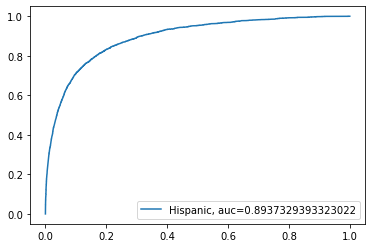

In [25]:
y_pred_proba = clf.predict_proba(X_val)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_val,  y_pred_proba)
auc = metrics.roc_auc_score(y_val, y_pred_proba)
plt.plot(fpr,tpr,label="Hispanic, auc="+str(auc))
plt.legend(loc=4)
plt.show()

### Jaccard Accuracy

In [26]:
metrics.accuracy_score(y_val, clf.predict(X_val))

0.9399

### 4. Explainability - proxy model drivers

In [27]:
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_train)
sv = np.array(shap_values)
y = clf.predict(X_train).astype("bool")
# shap values for high income
sv_target = sv[:,y,:]
# shap values for not high income
sv_nontarget = sv[:,~y,:]

In [ ]:
shap.summary_plot(shap_values[1], X_train.astype("float"))

In [ ]:
shap.summary_plot(shap_values[1], X_train.astype("float"), show=False)
plt.rcParams["figure.figsize"] = (25,15)
fig = plt.gcf().set_size_inches(factor * figure_size) 
fig.savefig('baba.png')

In [ ]:
fig.get_size_inches()

In [30]:
class ZiziCacaMixtape:
    def __init__(self):
        pass
    def __call__(self):
        return "j'adore le pipi"


In [ ]:
shap.summary_plot(shap_values[1], X_train.astype("float"))

# fig = plt.gcf().set_size_inches(15,15)

# # fig.set_size_inches(15,15)
# fig.savefig('test.png')

[2022-07-20 19:02:22,738 | DEBUG]	locator: <matplotlib.ticker.FixedLocator object at 0x7fa31dfcbdf0>


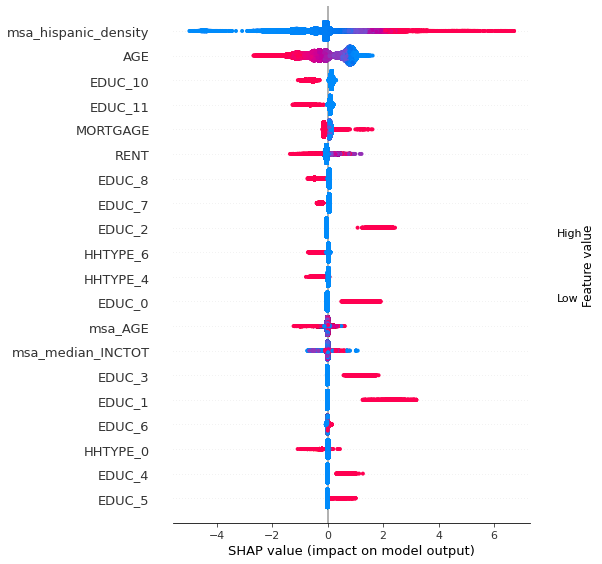

In [29]:
fig, ax = plt.subplots()
shap.summary_plot(shap_values[1], X_train.astype("float"), show=False)
fig.savefig('ab.png', bbox_inches='tight')

In [ ]:
shap.summary_plot(shap_values[1], X_train.astype("float"), show=False,
                  plot_size = 'auto')
plt.savefig('scratch.png')

In [ ]:
# Variable importance plot - how to read
# MSA_hispanic_density = percent of individuals who are hispanic in this MSA, historically
# Age = lower age, higher chance of being hispanic
# Educ 10 &11 = 4 years of college + graduate school = 1 = lower chance of being hispanic
# Income = higher = lower chance of being hispanic
shap.summary_plot(shap_values[1], X_train.astype("float"))

### Create proxy variable for Hispanic

In [ ]:
# Assign a binary indicator to the highest 7.1% of model scores - these are the proxy group
pg_rate = np.percentile(clf.predict_proba(X)[::,1], 100 - 7.1)

# Count number of individauls labeled among 80K training set
# np.where(clf.predict_proba(X_train)[::,1] > pg_rate,1,0).sum()

# Perform cross-tab - accuracy is so so - 3.0 k 1,1 | 2.7 k 1,0, TPR < 70%
pd.crosstab(model_data[dependent_bin], np.where(clf.predict_proba(X)[::,1] > pg_rate,1,0)) #.apply(lambda r: r/r.sum(), axis=1)

### 5. Train second income - predict top 20% of income

In [ ]:
# set parameters for bias check
dependent_2 = 'high_income'  # dependent variable we measure
dependent_bin_2 = 'high_income_bin'

# Positive rate
pos_rate = 0.2

In [ ]:
model_input_2 = model_data.copy()

model_input_2['high_income'] = np.where(model_input_2.INCTOT > np.percentile(model_input_2.INCTOT,80),1,0)
print(model_input_2['high_income'].value_counts(normalize=True))

model_input_2['hispanic'] = model_data[dependent_bin]
model_input_2['hispanic_proxy'] = np.where(clf.predict_proba(X)[::,1] > pg_rate,1,0)

### Historical bias

In [ ]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

print(model_input_2[['hispanic_proxy', 'high_income']].groupby(['hispanic_proxy']).mean())

print(model_input_2[['hispanic', 'high_income']].groupby(['hispanic']).mean())

### 6. Run RAI analysis - hispanic actual

In [ ]:
# set parameters for bias check
protected_group = 'hispanic'
protected_group_proxy = 'hispanic_proxy' 
outcome_advantage = 1
pg_disadvantage = 0 

In [ ]:
y_2 = model_input_2[dependent_2]

model_input_2.drop(['high_income', 'INCTOT'], axis=1, inplace=True)

X_train_2, X_val_2, y_train_2, y_val_2 = train_test_split(model_input_2,y_2,train_size=.8, random_state=42)


pg_train_2 = X_train_2[protected_group]
pg_train_proxy_2 = X_train_2[protected_group_proxy]

X_train_2.drop(['hispanic', 'hispanic_proxy'], axis=1, inplace=True)
X_val_2.drop(['hispanic', 'hispanic_proxy'], axis=1, inplace=True)

# X_train_2 = model_input_2.drop(labels=[dependent], axis=1)
# X_train_2 = X_train_2.drop(labels=['INCTOT'], axis=1)
# X_train_2 = X_train_2.drop(labels=[protected_group], axis=1)
# X_train_2 = X_train_2.drop(labels=[protected_group_proxy], axis=1)


# y_train_2 = model_input_2[dependent]

grid = {"n_estimators": [100, 200, 400],
        "max_depth": [4, 6, 8, 10]}

# Earlier model
# clf = LGBMClassifier(max_depth=3, n_estimators=1000, objective="binary")
# clf.fit(X_train,y_train, eval_set=(X_val,y_val), early_stopping_rounds=100, verbose=100) 

# Option 2 - RF
# rf_clf = RandomForestClassifier(class_weight="balanced", random_state=42)

clf_cv = GridSearchCV(clf, grid, cv=5, scoring="roc_auc", refit=True, verbose=3, n_jobs=-1)
clf_cv.fit(X_train_2, y_train_2)

best_estimator = clf_cv.best_estimator_
best_params = clf_cv.best_params_
print(best_params)

# best_estimator = RandomForestClassifier(max_depth=10, n_estimators=400, class_weight="balanced", random_state=42)
# best_estimator.fit(X_train, y_train)

In [ ]:
bias_ranker = ModelBiasRanker(best_estimator,
                              pos_rate= pos_rate,
                              bias_tolerance=0.2)

In [ ]:
bias_ranker.fit(X_train_2, y_train_2, pg_train_2)

In [ ]:
bias_ranker.results_

### 6. Run RAI analysis - hispanic proxy

In [ ]:
# y_train_2 = model_input_2[dependent]
pg_train = model_input_2[protected_group_proxy]

In [ ]:
bias_ranker = ModelBiasRanker(best_estimator,
                              pos_rate=pos_rate,
                              bias_tolerance=0.2)

In [ ]:
bias_ranker.fit(X_train_2, y_train_2, pg_train_proxy_2)

In [ ]:
bias_ranker.results_

### 7. Evaluate drivers of income models

In [ ]:
clf_2 = LGBMClassifier(max_depth=3, n_estimators=1000, objective="binary")
clf_2.fit(X_train_2,y_train_2, eval_set=(X_val_2,y_val_2), early_stopping_rounds=100, verbose=100) 

In [ ]:
explainer_2 = shap.TreeExplainer(clf_2)
shap_values_2 = explainer_2.shap_values(X_train_2)
sv_2 = np.array(shap_values_2)
y_2 = clf_2.predict(X_train_2).astype("bool")
# shap values for high income
sv_target_2 = sv_2[:,y_2,:]
# shap values for not high income
sv_nontarget_2 = sv_2[:,~y_2,:]

In [ ]:
# Variable importance plot - how to read
shap.summary_plot(shap_values_2[1], X_train_2.astype("float"))